In [1]:
import glob
import re
from collections import Counter
import json
from subprocess import Popen, PIPE
import os
import plotly.graph_objects as go

In [2]:
# Read all logFiles for all libraries
# logFiles = {}
# for f in glob.glob('/mnt/6TB/dockerMLcerts/attached_dir/CPT1/testing-resultsCPT1/zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5/logs/*openssl*'):
#     with open(f, "r", errors="replace") as fileO:
#         logFiles[(f.replace("output.", "").rsplit("/logs/", 1)[1].split(".")[0] + "-library-" + f.rsplit("-", 1)[1].split(".", 1)[0])] = fileO.readlines()
# print(len(logFiles))

import glob
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

log_dir = '/mnt/6TB/dockerMLcerts/attached_dir/CPT1/testing-resultsCPT1/zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5/logs/*openssl*'

# Find matching log files
log_paths = glob.glob(log_dir)

def read_log_file(file_path):
    try:
        with open(file_path, "r", errors="replace") as fileO:
            key = (file_path.replace("output.", "")
                            .rsplit("/logs/", 1)[1]
                            .split(".")[0] +
                   "-library-" +
                   file_path.rsplit("-", 1)[1].split(".", 1)[0])
            return key, fileO.readlines()
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return None

logFiles = {}
# NUM_THREADS = 32

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(read_log_file, f) for f in log_paths]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Reading Log Files"):
        result = future.result()
        if result:
            key, lines = result
            logFiles[key] = lines

print(f"Loaded {len(logFiles)} log files.")

Reading Log Files: 100%|█████████████████████████████████████████| 591466/591466 [05:47<00:00, 1702.47it/s]

Loaded 591466 log files.


In [3]:
# print(len(logFiles))

# # Only consider logFiles for whom DISCREPANCY of OpenSSL vs others
# uniqueDiscrepancies = {}
# for f in glob.glob('/mnt/6TB/dockerMLcerts/attached_dir/CPT1/testing-resultsCPT1/zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5/json/*'):
#     with open(f, "r") as fileO:
#         data = json.load(fileO)
#         this_pattern = ""
#         for elem in data:
#             this_pattern += str((int(data[elem] != 0)))
        
#         if this_pattern == "00000" or this_pattern == "11111":
# #             if this_pattern == "00000":
# #                 print(f)
#             continue
        
#         if this_pattern[0] == '0':
#             continue
        
#         if this_pattern not in uniqueDiscrepancies:
#             uniqueDiscrepancies[this_pattern] = set()
            
#         uniqueDiscrepancies[this_pattern].add((f.rsplit("/", 1)[1].replace("output.", "").split(".")[0]))
            
# print("Total discrepancies: ", len(uniqueDiscrepancies))
# print("\n")
# for discrepancy in uniqueDiscrepancies:
#     print(discrepancy, len(uniqueDiscrepancies[discrepancy]))

import glob
import os
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from collections import defaultdict

json_dir = '/mnt/6TB/dockerMLcerts/attached_dir/CPT1/testing-resultsCPT1/zmap-data-1024-3-0.0002lr-0.1dropout-epoch3-step300000T1.5/json/*'
json_files = glob.glob(json_dir)

def check_discrepancy(file_path):
    try:
        with open(file_path, "r") as fileO:
            data = json.load(fileO)
            this_pattern = ''.join([str(int(data[elem] != 0)) for elem in data])
            
            # Skip uniform patterns and ones where first entry is 0
            if this_pattern in ("00000", "11111") or this_pattern[0] == '0':
                return None
            
            simplified_name = file_path.rsplit("/", 1)[1].replace("output.", "").split(".")[0]
            return this_pattern, simplified_name
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

uniqueDiscrepancies = defaultdict(set)
# NUM_THREADS = 16

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(check_discrepancy, f) for f in json_files]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Checking Discrepancies"):
        result = future.result()
        if result:
            pattern, name = result
            uniqueDiscrepancies[pattern].add(name)

print("Total discrepancies: ", len(uniqueDiscrepancies))
print("\n")
for discrepancy, files in uniqueDiscrepancies.items():
    print(discrepancy, len(files))

Checking Discrepancies: 100%|████████████████████████████████████| 591466/591466 [04:18<00:00, 2289.87it/s]

Total discrepancies:  12


11001 3382
11011 19010
11110 2307
10010 6
11101 663
11010 218
10001 146
10011 122
11000 69
10000 46
10111 6
11100 7


In [145]:
# import numpy as np
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize =(10, 4))

# all_cps_order = []

# def parse_checkpoints(lines):
#     cps = set()
#     #cps.add("(started)")
#     for l in lines:
#         if "***CHECKPOINT***" in l:
#             cp = l.split("***CHECKPOINT***")[1].strip().split(" ")[0]
#             if "errorStatus:0" not in l:
#                 break
#             cps.add(cp)
            
#             if cp not in all_cps_order:
#                 all_cps_order.append(cp)
            
#             if "verify_cert" in cp:
#                 print(lines)
            
#     return cps

# cnt = Counter()
# for x in uniqueDiscrepancies:
#     #cnt = Counter()
#     print("Discrepancy ", x, "Number of certs", len(uniqueDiscrepancies[x]))
#     for y in uniqueDiscrepancies[x]:
#         if y+"-library-openssl" in logFiles:
#             for x in parse_checkpoints(logFiles[y+"-library-openssl"]):
#                 cnt[x] += 1

# labels = ["load_cert()", "build_chain()", "check_chain_extensions()", "check_auth_level()", "check_id()", "check_revocation()", "internal_verify()", "check_name_constraints()", "X509v3_addr_validate_path()"]
# labels = all_cps_order
# values = []
# for l in labels:
#     if l in cnt:
#         values.append(cnt[l])
#     else:
#         values.append(0)

# print(values)
# print(cnt)

# indexes = np.arange(len(labels))
# width = 1

# plt.plot(indexes, values, marker='o', c='blue', mfc='orange', mec='orange')
# plt.yscale('log',base=2)
# plt.ylim(1)
# plt.xlabel('Stage of validation')
# plt.ylabel('Certificates that pass each stage (log)')
# plt.xticks(indexes, labels, rotation=25)
# plt.show()

In [146]:
# Sankey diagram

# import plotly.graph_objects as go

# fig = go.Figure(data=[go.Sankey(
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = ["A1", "A2", "B1", "B2", "C1", "C2"],
#       color = "blue"
#     ),
#     link = dict(
#       source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
#       target = [2, 3, 3, 4, 4, 5],
#       value = [100, 4, 2, 8, 4, 2]
#   ))])

# fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
# fig.show()

In [134]:
all_cps_order = ["start"]

def parse_checkpoints(lines, disc_name):
    test = ''.join(lines)
    if "CHECKPOINT" not in test:
        assert False
    
    this_cps = []

    linesCheckpoint = []
    for l in lines:
        l = l.replace("certificate's notBefore field", "certificate's notBefore")
        l = l.replace("certificate's notAfter field", "certificate's notAfter")
        
        if "***CHECKPOINT***" in l:            
            # Not considering error checkpoints for now
            # if "ASN1_get_object" in l and "TOO_LONG" in l:
            #     continue
            
            l = l.replace("34", "unhandled critical extension")
            l = l.replace("10", "certificate has expired")
            linesCheckpoint.append(l)  
        
        elif "error" in l and "depth lookup:" in l:
            linesCheckpoint.append("***CHECKPOINT***programExitError passed errorStatus:" + l.split("depth lookup:")[1])

        # only for fig b
        elif ":error:" in l:
            linesCheckpoint = linesCheckpoint[:-1] + ["***CHECKPOINT***programExitDebugError passed errorStatus:" + l.split(":")[4] + "() " + l.split(":")[5]] + linesCheckpoint[-1:]
            break

    anyErrorPresent = False
    last = False
    for l in linesCheckpoint:
        # for fig a
        # if "programExitError" not in l:
        #     continue
            
        if not last:
#             if "load_cert()" not in l:
#                 break
            
            cp_func = l.split("***CHECKPOINT***")[1].strip().split(" ")[0] 
            cp_error = l.split("***CHECKPOINT***")[1].strip().split(" passed ")[1]
            cp = cp_func + " " + cp_error 
            
            cp = cp.replace("errorStatus:0", "passed")
            if "errorStatus" in cp:
                last = True
                anyErrorPresent = True
            
            if cp not in all_cps_order:
                all_cps_order.append(cp)

            this_cps.append(cp)  
            
    
    if anyErrorPresent is False:
        this_cps.append("programExitError not present")

    return this_cps

files_flagged = []
discs_flagged = []
all_certs = []
all_cps_distribution = {}
for disc in uniqueDiscrepancies:
    
    # if disc == "10001":
    #     print(uniqueDiscrepancies[disc])
    
    print("Discrepancy ", disc, "Number of certs", len(uniqueDiscrepancies[disc]))
    for y in uniqueDiscrepancies[disc]:
        all_certs.append(y)
        if y+"-library-openssl" in logFiles:
            all_cps_cert = parse_checkpoints(logFiles[y+"-library-openssl"], y)
            
            # if "ASN1_get_object" in all_cps_cert[-1] and "ASN1_R_TOO_LONG" in all_cps_cert[-1]:
            #     files_flagged.append(y)
            #     discs_flagged.append(disc)
            
#             for l in logFiles[y+"-library-openssl"]:
#                 if "asn1_lib.c:91" in l:
#                     print(disc, y)
#                     break
            
            prev = "start"
        
            for x in all_cps_cert:
                #print(x)
                if prev not in all_cps_distribution:
                    all_cps_distribution[prev] = {}
                
                if x not in all_cps_distribution[prev]:
                    all_cps_distribution[prev][x] = 0
                
                all_cps_distribution[prev][x] += 1
                
                prev = x

all_cps_order.append("programExitError not present")
                
sources = []
targets = []
values = []
for x in all_cps_distribution:
    for y in all_cps_distribution[x]:
#         if x == "start":
#             print("HI")
#             print(all_cps_distribution[x][y])
        values.append(all_cps_distribution[x][y])
        sources.append(all_cps_order.index(x))
        targets.append(all_cps_order.index(y))

# print(sources)
colors = []
for s in all_cps_order:
    if "passed" in s or "start" in s:
        colors.append("blue")
    elif "programExitError" in s:
        colors.append("black")
    else:
        colors.append("red")
    
# print(all_cps_distribution)
# print(all_cps_order)

Discrepancy  11001 Number of certs 3382
Discrepancy  11011 Number of certs 19010
Discrepancy  11110 Number of certs 2307
Discrepancy  10010 Number of certs 6
Discrepancy  11101 Number of certs 663
Discrepancy  11010 Number of certs 218
Discrepancy  10001 Number of certs 146
Discrepancy  10011 Number of certs 122
Discrepancy  11000 Number of certs 69
Discrepancy  10000 Number of certs 46
Discrepancy  10111 Number of certs 6
Discrepancy  11100 Number of certs 7


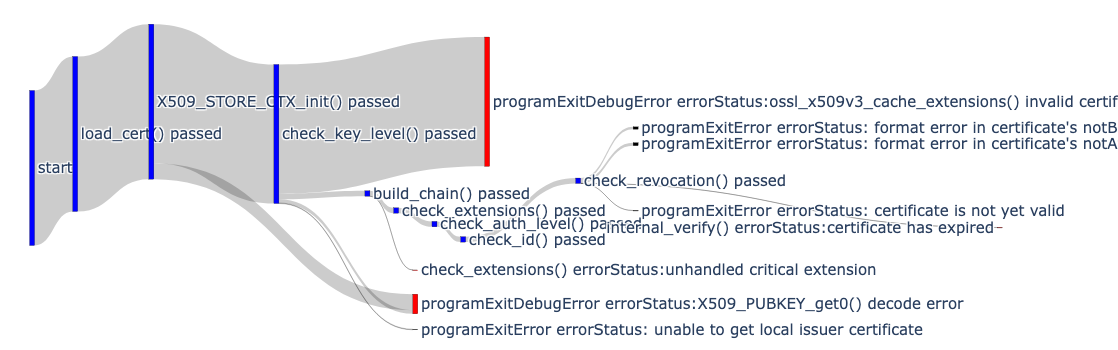

In [282]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 5,
      line = dict(color = "black", width = 0.25),
      label = all_cps_order,
      align = 'left',
      color = colors,
      # for fig b
      x = [-0.05, -0.005, 0.0745, 0.205, 0.425, 0.35, 0.3, 0.35, 0.35, 0.33, 0.37, 0.4, 0.52, 0.58, 0.58, 0.58, 0.96],
      y = [0.4, 0.2, 0.01, 0.2, 0.01, 1.35, 0.55, 1, 1.2, 0.65, 0.73, 0.82, 0.475, 0.165, 0.26, 0.65, 0.75],
      # for fig a
      # x = [-0.05, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.85],
      # y = [0.5, -0.2, 0.975, 0.6, 0.7, 1.35, 1.2, 0.2],
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values
  ))])

fig.update_layout(title_text="", font_size=15, width=1200, height=350)
fig.show()
fig.write_image("fig1.pdf")